**MALICIOUS WEBPAGE DETECTION USING SUPERVISED LEARNING METHODS**

We analyze the data about webpages that contains attributes such as url and ip address and classify webpages as malicious or benign.

We use these methods:
- Logistic Regression
- Decision Tree
- Naive Bayes
- Support Vector Machines

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# maps
import nbformat
import base64
from base64 import encodestring
from base64 import encodebytes

import re   # regular expression
import string
import nltk   # natural language processing toolkit
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm   # porgress bar
from scipy import stats   # scientific computing

import sklearn
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score

# methods
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Miracetdin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**1. Load Dataset**

In [3]:
# load the dataset and general information about the dataset
df_dataset = pd.read_csv('datasets/small_dataset.csv').rename(columns={"Unnamed: 0": "index"})
df_dataset.axes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       50000 non-null  int64  
 1   index       50000 non-null  int64  
 2   url         50000 non-null  object 
 3   url_len     50000 non-null  int64  
 4   ip_add      50000 non-null  object 
 5   geo_loc     50000 non-null  object 
 6   tld         50000 non-null  object 
 7   who_is      50000 non-null  object 
 8   https       50000 non-null  object 
 9   js_len      50000 non-null  float64
 10  js_obf_len  50000 non-null  float64
 11  content     50000 non-null  object 
 12  label       50000 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 5.0+ MB


In [149]:
# write a small dataset
# df_dataset.iloc[0:50000].to_csv('small_dataset.csv')

In [150]:
# samples datas
df_dataset.head()

,index,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,0,http://members.tripod.com/russiastation/,40,42.77.221.155,Taiwan,com,complete,yes,58.0,0.0,Named themselves charged particles in a manly ...,good
1,1,http://www.ddj.com/cpp/184403822,32,3.211.202.180,United States,com,complete,yes,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,good
2,2,http://www.naef-usa.com/,24,24.232.54.41,Argentina,com,complete,yes,103.5,0.0,"Took in cognitivism, whose adherents argue for...",good
3,3,http://www.ff-b2b.de/,21,147.22.38.45,United States,de,incomplete,no,720.0,532.8,fire cumshot sodomize footaction tortur failed...,bad
4,4,http://us.imdb.com/title/tt0176269/,35,205.30.239.85,United States,com,complete,yes,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",good


In [151]:
# label distribution
df_dataset.label.describe()

count     1200000
unique          2
top          good
freq      1172747
Name: label, dtype: object

- Preprocessing of Data Exploration

In [152]:
# country codes dataset
df_country = pd.read_csv('datasets\iso_country_codes.csv').rename(columns={'English short name lower case': 'Country'})
df_country.head()

,Country,Alpha-2 code,Alpha-3 code,Numeric code,ISO 3166-2
0,Afghanistan,AF,AFG,4.0,ISO 3166-2:AF
1,Åland Islands,AX,ALA,248.0,ISO 3166-2:AX
2,Albania,AL,ALB,8.0,ISO 3166-2:AL
3,Algeria,DZ,DZA,12.0,ISO 3166-2:DZ
4,American Samoa,AS,ASM,16.0,ISO 3166-2:AS


In [153]:
# adding a feature which iso alpha 3 code for countries
countries = dict(zip(df_country['Country'], df_country['Alpha-3 code']))

df_dataset['country'] = df_dataset['geo_loc']
df_dataset['country'].replace(countries, inplace=True)
df_dataset.head()

,index,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label,country
0,0,http://members.tripod.com/russiastation/,40,42.77.221.155,Taiwan,com,complete,yes,58.0,0.0,Named themselves charged particles in a manly ...,good,TWN
1,1,http://www.ddj.com/cpp/184403822,32,3.211.202.180,United States,com,complete,yes,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,good,USA
2,2,http://www.naef-usa.com/,24,24.232.54.41,Argentina,com,complete,yes,103.5,0.0,"Took in cognitivism, whose adherents argue for...",good,ARG
3,3,http://www.ff-b2b.de/,21,147.22.38.45,United States,de,incomplete,no,720.0,532.8,fire cumshot sodomize footaction tortur failed...,bad,USA
4,4,http://us.imdb.com/title/tt0176269/,35,205.30.239.85,United States,com,complete,yes,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",good,USA


In [154]:
# adding network type feature
# Identifying the type of network [A, B, C]
def network_type(ip):
    ip_str = ip.split(".")
    ip = [int(x) for x in ip_str]

    if ip[0] >= 0 and ip[0] <= 127:
        return (ip_str[0], "A")
    elif ip[0] >= 128 and ip[0] <= 191:
        return (".".join(ip_str[0:2]), "B")
    else:
        return (".".join(ip_str[0:3]), "C")


df_dataset['Network'] = df_dataset['ip_add'].apply(lambda x: network_type(x))
# df_dataset['net_part'], df_dataset['net_type'] = zip(*df_dataset.Network)
_, df_dataset['net_type'] = zip(*df_dataset.Network)
df_dataset.drop(columns=['Network'], inplace=True)
df_dataset.head()

,index,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label,country,net_type
0,0,http://members.tripod.com/russiastation/,40,42.77.221.155,Taiwan,com,complete,yes,58.0,0.0,Named themselves charged particles in a manly ...,good,TWN,A
1,1,http://www.ddj.com/cpp/184403822,32,3.211.202.180,United States,com,complete,yes,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,good,USA,A
2,2,http://www.naef-usa.com/,24,24.232.54.41,Argentina,com,complete,yes,103.5,0.0,"Took in cognitivism, whose adherents argue for...",good,ARG,A
3,3,http://www.ff-b2b.de/,21,147.22.38.45,United States,de,incomplete,no,720.0,532.8,fire cumshot sodomize footaction tortur failed...,bad,USA,B
4,4,http://us.imdb.com/title/tt0176269/,35,205.30.239.85,United States,com,complete,yes,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",good,USA,C


In [155]:
# label attribute changes -> bad:Malicious, good:Benign
df_dataset.label.replace({'bad': 'Malicious', 'good': 'Benign'}, inplace=True)
df_dataset.head()

,index,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label,country,net_type
0,0,http://members.tripod.com/russiastation/,40,42.77.221.155,Taiwan,com,complete,yes,58.0,0.0,Named themselves charged particles in a manly ...,Benign,TWN,A
1,1,http://www.ddj.com/cpp/184403822,32,3.211.202.180,United States,com,complete,yes,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,Benign,USA,A
2,2,http://www.naef-usa.com/,24,24.232.54.41,Argentina,com,complete,yes,103.5,0.0,"Took in cognitivism, whose adherents argue for...",Benign,ARG,A
3,3,http://www.ff-b2b.de/,21,147.22.38.45,United States,de,incomplete,no,720.0,532.8,fire cumshot sodomize footaction tortur failed...,Malicious,USA,B
4,4,http://us.imdb.com/title/tt0176269/,35,205.30.239.85,United States,com,complete,yes,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",Benign,USA,C


In [156]:
# HTTPS column -> yes: HTTPS, no: HTTP
df_dataset.https.replace({'yes' : 'HTTPS', 'no' : 'HTTP'}, inplace = True)
df_dataset.head()

,index,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label,country,net_type
0,0,http://members.tripod.com/russiastation/,40,42.77.221.155,Taiwan,com,complete,HTTPS,58.0,0.0,Named themselves charged particles in a manly ...,Benign,TWN,A
1,1,http://www.ddj.com/cpp/184403822,32,3.211.202.180,United States,com,complete,HTTPS,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,Benign,USA,A
2,2,http://www.naef-usa.com/,24,24.232.54.41,Argentina,com,complete,HTTPS,103.5,0.0,"Took in cognitivism, whose adherents argue for...",Benign,ARG,A
3,3,http://www.ff-b2b.de/,21,147.22.38.45,United States,de,incomplete,HTTP,720.0,532.8,fire cumshot sodomize footaction tortur failed...,Malicious,USA,B
4,4,http://us.imdb.com/title/tt0176269/,35,205.30.239.85,United States,com,complete,HTTPS,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",Benign,USA,C


**2. Data Exploration**

- Distribution of Webpage Types

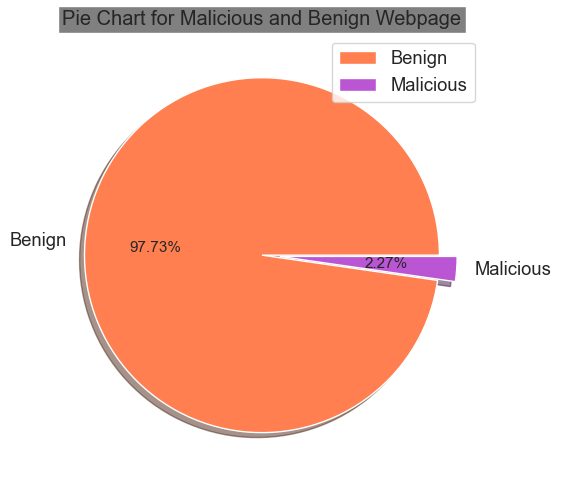

In [157]:
# Setting the parameters
plt.rcParams['figure.figsize'] = [13, 5]
# sns.set(style = 'white', font_scale=1.3)
# fig, ax = plt.subplots(1, 2)
ax = plt.subplots()
# Bar graph
# bar = sns.countplot(df_dataset.label, data=df_dataset, ax=ax[0], palette=['coral', 'mediumorchid'])
# bar.set(xlabel='Webpage Type', ylabels='Count')
# bar.set_title("Distribution of Malicious and Benign Webpage", bbox={'facecolor': '0.8', 'pad': 5})

# Creating the labels for the piechart
types = df_dataset['label'].value_counts()
labels = list(types.index)
aggregate = list(types.values)
# percentage = [(x*100)/sum(aggregate) for x in aggregate]
# print ("The percentages of Benign and Malicious Webpages are : ", percentage)

# Plotting the Piechart to see the percentage distribution of the Webpages
plt.rcParams.update({'font.size': 11})
explode = (0, 0.1)
ax[1].pie(aggregate, labels=labels, autopct='%1.2f%%', shadow=True, explode=explode, colors=['coral', 'mediumorchid'])
plt.title("Pie Chart for Malicious and Benign Webpage", bbox={'facecolor': '0.5', 'pad': 3})
plt.legend(labels, loc='best')
plt.tight_layout()
plt.show()

- Malicious and Bening Webpages Distribution by Countries

In [158]:
# Malicious Webpages Distribution
# Iso alpha 3 codes are necessary for choropleth plots [not particulary necessary though :)]
df_mal = df_dataset.loc[df_dataset.label == 'Malicious', :]

val_mal = df_mal.country.value_counts()
val_mal = pd.DataFrame(val_mal)
val_mal

,country
USA,11678
CHN,2661
JPN,1579
DEU,979
SKR,823
...,...
LKA,1
MDV,1
MMR,1
WLF,1


In [159]:
# Benign Webpages Distribution
# Iso alpha 3 codes are necessary for choropleth plots [not particulary necessary though :)]
df_ben = df_dataset.loc[df_dataset.label == 'Benign', :]

val_ben = df_ben.country.value_counts()
val_ben = pd.DataFrame(val_ben)
val_ben

,country
USA,501718
CHN,110998
JPN,67207
DEU,41142
GBR,37052
...,...
NIU,1
KIR,1
SHN,1
ATA,1


- Map of Malicious Webpages Distribution

In [160]:
# Choropleth Map
fig = go.Figure(data = go.Choropleth(
    locations = val_mal.index,
    z = val_mal.country,
#     text = val.index,
    colorscale = 'reds',
    autocolorscale = False,
    reversescale = False,
    marker_line_color = 'darkgray',
    marker_line_width = 0.5,
    colorbar_title = 'Number of Webpages',
))

fig.update_layout(
    title_text = 'Malicious Webpages Around the World',
    geo = dict(
        showframe = False,
        showcoastlines = False,
#         projection_type = 'equirectangular'
    ),
    annotations = [dict(
        x = 0.55,
        y = 0.1,
        xref = 'paper',
        yref = 'paper',
        text = 'Source: <a href="https://data.mendeley.com/datasets/gdx3pkwp47/2">\Dataset [Mendeley Data] </a>',
        showarrow = False
    )]
)

fig.show()

- Map of Benign Webpages

In [161]:
# Choropleth Map
fig = go.Figure(data = go.Choropleth(
    locations = val_ben.index,
    z = val_ben.country,
#     text = val.index,
    colorscale = 'blues',
    autocolorscale = False,
    reversescale = False,
    marker_line_color = 'darkgray',
    marker_line_width = 0.5,
    colorbar_title = 'Number of Webpages',
))

fig.update_layout(
    title_text = 'Benign Webpages Around the World',
    geo = dict(
        showframe = False,
        showcoastlines = False,
#         projection_type = 'equirectangular'
    ),
    annotations = [dict(
        x = 0.55,
        y = 0.1,
        xref = 'paper',
        yref = 'paper',
        text = 'Source: <a href="https://data.mendeley.com/datasets/gdx3pkwp47/2">\
            Dataset [Mendeley Data] </a>',
        showarrow = False
    )]
)

fig.show()

- Network Types Over Malicious and Benign Webpages

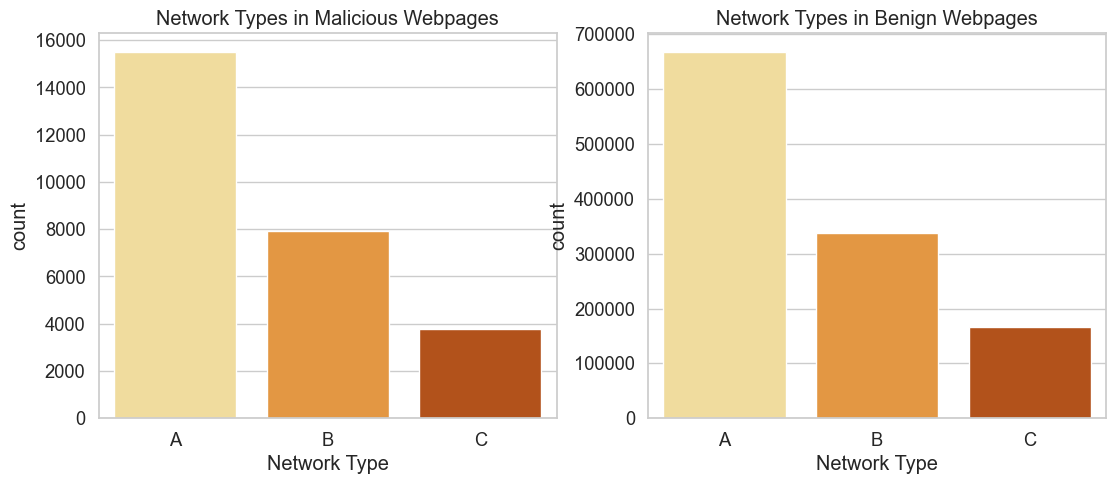

In [162]:
plt.rcParams['figure.figsize'] = [13, 5]
sns.set(style = 'whitegrid', font_scale = 1.2)

fig, ax = plt.subplots(1, 2)
bar_1 = sns.countplot(x = 'net_type', data = df_mal, order = ['A', 'B', 'C'], palette = 'YlOrBr', ax = ax[0])
bar_1.set(title = 'Network Types in Malicious Webpages', xlabel = 'Network Type')

bar_2 = sns.countplot(x = 'net_type', data = df_ben, order = ['A', 'B', 'C'], palette = 'YlOrBr', ax = ax[1])
bar_2.set(title = 'Network Types in Benign Webpages', xlabel = 'Network Type');

- HTTPS and HTTP Protocols Distribution

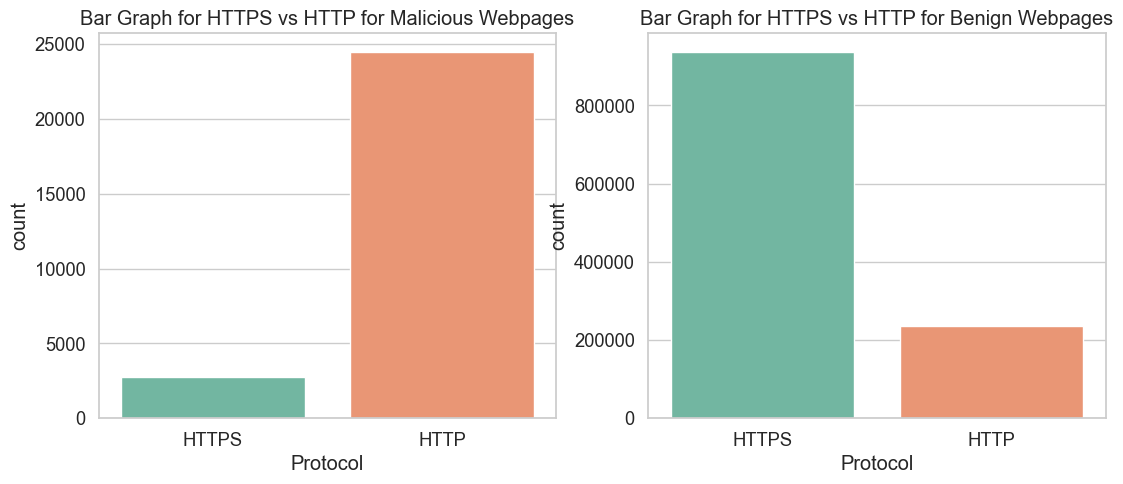

In [163]:
plt.rcParams['figure.figsize'] = [13, 5]
sns.set(style = 'whitegrid', font_scale = 1.2)

fig, ax = plt.subplots(1, 2)
bar_1 = sns.countplot(x = 'https', data = df_mal, order = ['HTTPS', 'HTTP'], palette = 'Set2', ax = ax[0])
bar_1.set(title = 'Bar Graph for HTTPS vs HTTP for Malicious Webpages', xlabel = 'Protocol')

bar_2 = sns.countplot(x = 'https', data = df_ben, order = ['HTTPS', 'HTTP'], palette = 'Set2', ax = ax[1])
bar_2.set(title = 'Bar Graph for HTTPS vs HTTP for Benign Webpages', xlabel = 'Protocol');

- Bar graph showing the most used TLD in URLs over Malicious and Benign Webpages

In [164]:
mal_tld = pd.DataFrame(df_mal.tld.value_counts()[:10])
ben_tld = pd.DataFrame(df_ben.tld.value_counts()[:10])

mal = go.Bar(y = mal_tld.tld, x = mal_tld.index.tolist(), text = mal_tld.tld, marker_color = 'indianred')
ben = go.Bar(y = ben_tld.tld, x = ben_tld.index.tolist(), text = ben_tld.tld, marker_color = 'lightsalmon')

fig = make_subplots(
    rows = 2, cols = 1, subplot_titles = ("Most Occuring Top Level Domain in Malicious Webpages", "Most Occuring Top Level Domain in Benign Webpages"),
    specs = [[{'type' : 'bar'}], [{'type' : 'bar'}]]
)

fig.append_trace(mal, row = 1, col = 1)
fig.append_trace(ben, row = 2, col = 1)
fig.update_traces(texttemplate = '%{text:.2s}', textposition = 'outside')
fig.update_layout(uniformtext_minsize = 10, uniformtext_mode = 'hide', width = 1200, height = 900)

fig.show()

**3. Preprocessing**

- Dropping Useless Features

In [165]:
# detection missing values
df_dataset.isna().sum()

index         0
url           0
url_len       0
ip_add        0
geo_loc       0
tld           0
who_is        0
https         0
js_len        0
js_obf_len    0
content       0
label         0
country       0
net_type      0
dtype: int64

In [166]:
df_dataset.head()

,index,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label,country,net_type
0,0,http://members.tripod.com/russiastation/,40,42.77.221.155,Taiwan,com,complete,HTTPS,58.0,0.0,Named themselves charged particles in a manly ...,Benign,TWN,A
1,1,http://www.ddj.com/cpp/184403822,32,3.211.202.180,United States,com,complete,HTTPS,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,Benign,USA,A
2,2,http://www.naef-usa.com/,24,24.232.54.41,Argentina,com,complete,HTTPS,103.5,0.0,"Took in cognitivism, whose adherents argue for...",Benign,ARG,A
3,3,http://www.ff-b2b.de/,21,147.22.38.45,United States,de,incomplete,HTTP,720.0,532.8,fire cumshot sodomize footaction tortur failed...,Malicious,USA,B
4,4,http://us.imdb.com/title/tt0176269/,35,205.30.239.85,United States,com,complete,HTTPS,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",Benign,USA,C


In [167]:
# dropping columns
df_dataset.drop(['index', 'geo_loc', 'url', 'ip_add'], axis=1, inplace=True)
df_dataset.head()

,url_len,tld,who_is,https,js_len,js_obf_len,content,label,country,net_type
0,40,com,complete,HTTPS,58.0,0.0,Named themselves charged particles in a manly ...,Benign,TWN,A
1,32,com,complete,HTTPS,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,Benign,USA,A
2,24,com,complete,HTTPS,103.5,0.0,"Took in cognitivism, whose adherents argue for...",Benign,ARG,A
3,21,de,incomplete,HTTP,720.0,532.8,fire cumshot sodomize footaction tortur failed...,Malicious,USA,B
4,35,com,complete,HTTPS,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",Benign,USA,C


- Special Characters of Webpages Contents

In [168]:
# Counting the Special Characters in the content
def count_special(string):
    count = 0
    for char in string:
        if not(char.islower()) and not(char.isupper()) and not(char.isdigit()):
            if char != ' ':
                count += 1
    return count

# Adding Feature that shows the Number of Special Character in the Content
df_dataset['special_char'] = df_dataset['content'].apply(lambda x: count_special(x))
df_dataset.head()

,url_len,tld,who_is,https,js_len,js_obf_len,content,label,country,net_type,special_char
0,40,com,complete,HTTPS,58.0,0.0,Named themselves charged particles in a manly ...,Benign,TWN,A,74
1,32,com,complete,HTTPS,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,Benign,USA,A,51
2,24,com,complete,HTTPS,103.5,0.0,"Took in cognitivism, whose adherents argue for...",Benign,ARG,A,109
3,21,de,incomplete,HTTP,720.0,532.8,fire cumshot sodomize footaction tortur failed...,Malicious,USA,B,718
4,35,com,complete,HTTPS,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",Benign,USA,C,58


- Lengths of The Webpages Contents

    We use the lenghts of the contents instead of the contents

In [169]:
# Length of the Content
df_dataset['content_len'] = df_dataset['content'].apply(lambda x: len(x))
df_dataset.drop(['content'], axis=1, inplace=True)
df_dataset.head()

,url_len,tld,who_is,https,js_len,js_obf_len,label,country,net_type,special_char,content_len
0,40,com,complete,HTTPS,58.0,0.0,Benign,TWN,A,74,1155
1,32,com,complete,HTTPS,52.5,0.0,Benign,USA,A,51,611
2,24,com,complete,HTTPS,103.5,0.0,Benign,ARG,A,109,1320
3,21,de,incomplete,HTTP,720.0,532.8,Malicious,USA,B,718,8946
4,35,com,complete,HTTPS,46.5,0.0,Benign,USA,C,58,722


- Convert Categorical Features Into Numeric Features

In [170]:
# These are the categorical features that needs to be converted into numeric features for modelling 
categorical = df_dataset.select_dtypes('object').columns.tolist()
ls = [element for element in categorical if element not in ['label']]
ls

['tld', 'who_is', 'https', 'country', 'net_type']

In [171]:
# This le_dict will save the Label Encoder Class so that the same Label Encoder instance can be used for the test dataset
le_dict = {}

for feature in ls:
    le = LabelEncoder()
    le_dict[feature] = le
    df_dataset[feature] = le.fit_transform(df_dataset[feature])

df_dataset.label.replace({'Malicious' : 1, 'Benign' : 0}, inplace = True)
df_dataset.head()

,url_len,tld,who_is,https,js_len,js_obf_len,label,country,net_type,special_char,content_len
0,40,195,0,1,58.0,0.0,0,213,0,74,1155
1,32,195,0,1,52.5,0.0,0,220,0,51,611
2,24,195,0,1,103.5,0.0,0,7,0,109,1320
3,21,282,1,0,720.0,532.8,1,220,1,718,8946
4,35,195,0,1,46.5,0.0,0,220,2,58,722


- Nomalization - Standartization

In [172]:
# Normalizing the 'content_len' and 'special_char' in training data
ss_dict = {}

for feature in ['content_len', 'special_char', 'url_len', 'tld', 'js_len', 'js_obf_len', 'country']:
    ss = StandardScaler()
    ss_fit = ss.fit(df_dataset[feature].values.reshape(-1, 1))
    ss_dict[feature] = ss_fit
    d = ss_fit.transform(df_dataset[feature].values.reshape(-1, 1))
    df_dataset[feature] = pd.DataFrame(d, index = df_dataset.index, columns = [feature])

df_dataset.head()

,url_len,tld,who_is,https,js_len,js_obf_len,label,country,net_type,special_char,content_len
0,0.287743,-0.546414,0,1,-0.675901,-0.135859,0,0.840422,0,-0.770540,-0.452765
1,-0.267393,-0.546414,0,1,-0.736697,-0.135859,0,0.930792,0,-1.020689,-0.958673
2,-0.822529,-0.546414,0,1,-0.172952,-0.135859,0,-1.819036,0,-0.389878,-0.299318
3,-1.030705,-0.246055,1,0,6.641729,8.742076,1,0.930792,1,6.233631,6.792698
4,-0.059217,-0.546414,0,1,-0.803020,-0.135859,0,0.930792,2,-0.944556,-0.855445


**4. Train and Test**

In [173]:
x = df_dataset.drop('label', axis=1)
y = df_dataset.label

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [174]:
# Classificaation
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'Support Vector Machines': SVC()
}
results=pd.DataFrame(columns=['Accuracy in %', 'F1-score', 'Recall', 'Precision'])
for method, func in classifiers.items():
    func.fit(x_train,y_train)
    pred = func.predict(x_test)
    results.loc[method]= [100*np.round(accuracy_score(y_test,pred),decimals=4),
                         round(f1_score(y_test,pred),2),
                         round(recall_score(y_test,pred),2),
                         round(precision_score(y_test,pred),2)]
results

,Accuracy in %,F1-score,Recall,Precision
Logistic Regression,99.78,0.95,0.93,0.97
Decision Tree,99.93,0.99,0.99,0.98
Naive Bayes,99.88,0.97,0.95,1.00
Support Vector Machines,99.96,0.99,0.99,0.99
